In [1]:
import os
import tqdm
import math
import torch
import random
import warnings
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, TensorDataset

warnings.filterwarnings("ignore")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def shape_print(arr):
    print(tuple(arr.shape))

In [2]:
N_BATCH = -1
LENGTH = 100
N_SERIES = 1

temp = np.sin(np.linspace(0, 40*np.pi, 120000)) + np.random.normal(0, 0.02, 120000)
arr = list()
for i in range(0, temp.shape[0] - LENGTH, LENGTH):
    s = torch.tensor(temp[i:i+LENGTH], dtype = torch.float32)
    if s.shape[0] == LENGTH:
        arr += [s]
arr = torch.vstack(arr).reshape(N_BATCH, LENGTH, N_SERIES)
print("(N_BATCH, LENGTH, N_SERIES) =", end = " ")
shape_print(arr)

(N_BATCH, LENGTH, N_SERIES) = (1199, 100, 1)


In [3]:
class Shape_Check(nn.Module):
    def __init__(self, length, n_series):
        super(Shape_Check, self).__init__()
        self.length, self.n_series = length, n_series
    
    def forward(self, x):
        if x.shape[1:] != (self.length, self.n_series):
            word = "Shape does not fit! It shall be (N_BATCH, {}, {}) ".format(self.length, self.n_series)
            word += "But get ()".format(tuple(x.shape))
            raise RuntimeError(word)
        return x

class Permute(nn.Module):
    def __init__(self, *n_dim):
        super(Permute, self).__init__()
        self.dims = n_dim
        
    def forward(self, x):
        return x.permute(self.dims)
    
class Encoder(nn.Module):
    def __init__(self, d_model, n_head, n_layer):
        super(Encoder, self).__init__()
        enc = nn.TransformerEncoderLayer(d_model = d_model, nhead = n_head)
        self.enc = nn.TransformerEncoder(enc, num_layers=n_layer)
    def forward(self, x):
        return self.enc(x)
    
class MatMul(nn.Module):
    def __init__(self, y):
        super(MatMul, self).__init__()
        self.y = y
    def forward(self, x):
        return x@self.y
    
class Memory_Attention(nn.Module):
    def __init__(self, d_model):
        super(Memory_Attention, self).__init__()
        self.d_model = np.sqrt(d_model)
    def forward(self, Tuple):
        qs, memory = Tuple
        s = qs@memory.T/self.d_model
        s = s.permute(0, 2, 1)
        v = nn.Softmax(dim = 2)(s)
        r = v@qs
        return r, memory
    
class U_W_psi(nn.Module):
    def __init__(self, d_model):
        super(U_W_psi, self).__init__()
        self.U_psi = nn.Linear(d_model, d_model, bias = False)
        self.W_psi = nn.Linear(d_model, d_model, bias = False)
    def forward(self, Tuple):
        r, memory = Tuple
        r_mean = r.mean(dim = 0)
        psi = nn.Sigmoid()(self.U_psi(memory) + self.W_psi(r_mean))
        return (1 - psi)*memory + psi*r_mean
    
class Retrieve(nn.Module):
    def __init__(self, d_model):
        super(Retrieve, self).__init__()
        self.d_model = np.sqrt(d_model)
    def forward(self, Tuple):
        qs, memory = Tuple
        rr = qs@memory.T/self.d_model
        rr = nn.Softmax(dim = 2)(rr)
        q_telta = rr@memory
        q_hat = torch.cat([qs, q_telta], dim = -1)
        return q_hat, rr

In [4]:
from sklearn.cluster import KMeans

class MEMTO(nn.Module):
    def __init__(self, length, n_series, d_model, n_head, n_layer, n_memory, x, device = "cuda"):
        super(MEMTO, self).__init__()
        # Encoder Block
        self.encoder = nn.Sequential(
            Shape_Check(length, n_series), # (N_BATCH, LENGTH, N_SERIES)
            nn.Linear(n_series, d_model), # Embedded to (N_BATCH, LENGTH, D_MODEL)
            Permute(1, 0, 2), # Permute to (LENGTH, N_BATCH, D_MODEL)
            Encoder(d_model, n_head, n_layer), # Encode to (LENGTH, N_BATCH, D_MODEL)
            Permute(1, 0, 2) # Permute to (N_BATCH, LENGTH, D_MODEL)
        )
        
        # Memory init
        q = self.encoder(x).reshape(-1, d_model).detach().numpy()
        self.memory = nn.Parameter(
            torch.tensor(
                KMeans(n_clusters=n_memory, random_state=42).fit(q).cluster_centers_, dtype=torch.float) # (N_MEMORY, D_MODEL)
        ).to(device)
        
        # Memory update gate
        self.memory_gate = nn.Sequential(
            Memory_Attention(d_model), # Attention from qs, memory to (N_BATCH, N_MEMORY, LENGTH), memory
            U_W_psi(d_model) # New memory still (N_MEMORY, D_MODEL)
        )
        
        # Memory retrieve gate
        self.memory_retrieve = nn.Sequential(
            Retrieve(d_model) # Retrieve to (N_BATCH, LENGTH, 2*D_MODEL)
        )
        
        # Decoder Block
        self.decoder = nn.Sequential(
            nn.Linear(2*d_model, d_model), # Dense to (N_BATCH, LENGTH, D_MODEL)
            nn.ReLU(),
            nn.Linear(d_model, n_series) # Dense to (N_BATCH, LENGTH, N_SERIES)
        )
        self.device = device
        self.to(device)
    
    def forward(self, x):
        x = x.to(self.device)
        qs = self.encoder(x)
        new_memory = self.memory_gate((qs, self.memory))
        q, _ = self.memory_retrieve((qs, new_memory))
        recon = self.decoder(q)
        return recon
        
    def fit(self, dataloader, epochs):
        self.train()
        optimizer = optim.Adam(self.parameters(), lr = 5e-5)
        for epoch in range(1, epochs + 1):
            num_loss = 0.0
            for data in dataloader:
                # Inference
                data = data.to(self.device)
                qs = self.encoder(data)
                new_memory = self.memory_gate((qs, self.memory))
                q, rr = self.memory_retrieve((qs, new_memory))
                recon = self.decoder(q)

                loss = nn.MSELoss()(data, recon)
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                loss += .01*torch.mean(torch.sum((torch.sum(-rr*torch.log(rr+1e-8), dim = -1)), dim = -1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                num_loss += loss.item()
                with torch.no_grad():
                    self.memory.data.copy_(new_memory.data)
            print("[Epoch {}] Train-Loss={}".format(epoch, round(num_loss, 4)), end = "\r")
            
    def anomaly_score(self, x):
        self.eval()
        with torch.no_grad():
            res = list()
            dataloader = DataLoader(x, batch_size=32, shuffle=False)
            for data in dataloader:
                data = data.to(self.device)
                qs = self.encoder(data)
                new_memory = self.memory_gate((qs, self.memory))
                q, rr = model.memory_retrieve((qs, new_memory))
                recon = model.decoder(q)
                
                # LSD
                memory_expanded = new_memory.unsqueeze(0).unsqueeze(0) # (1, 1, N_MEMORY, d_model)
                qs_expanded = qs.unsqueeze(2) # (N_BATCH, LENGTH, 1, d_model)
                diff = qs_expanded - memory_expanded # (N_BATCH, LENGTH, N_MEMORY, d_model)
                dist_sq = torch.sum(diff**2, dim=-1) # (N_BATCH, LENGTH, N_MEMORY)
                LSD, _ = torch.min(dist_sq, dim=-1) # (N_BATCH, LENGTH)
                LSD_norm = nn.Softmax(dim=1)(LSD) # (N_BATCH, LENGTH)
                
                # ISD
                ISD = torch.sum((data - recon)**2, dim=-1) # (N_BATCH, LENGTH)
                
                # Score
                anomaly_score = LSD_norm * ISD # (N_BATCH, LENGTH)
                res += [anomaly_score] # (N_BATCH, )
            return torch.vstack(res).reshape(-1, 1)
            
                
D_MODEL = 8
N_HEAD = 8
N_MEMORY = 10
N_LAYER = 6
    
    
model = MEMTO(length = LENGTH, 
              n_series = N_SERIES, 
              d_model = D_MODEL, 
              n_head = N_HEAD, 
              n_layer = N_LAYER, 
              n_memory = N_MEMORY,
              x = arr,
              device = "cuda"
             )
model.to("cuda")
tr_loader = DataLoader(arr, batch_size=32, shuffle=True)
model.fit(tr_loader, 100)

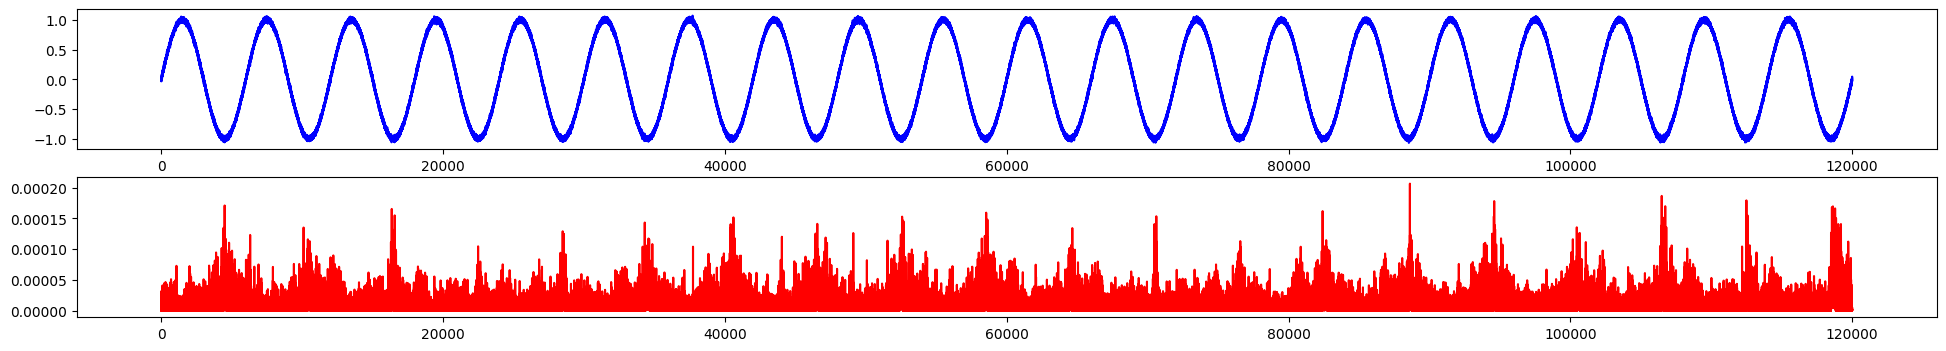

In [5]:
scores = model.anomaly_score(arr)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize = (24, 4))
ax0, ax1 = ax
ax0.plot(temp, color = "blue")
ax1.plot(np.linspace(0, temp.shape[0], len(scores)), scores.cpu().detach().numpy(), color = "red")

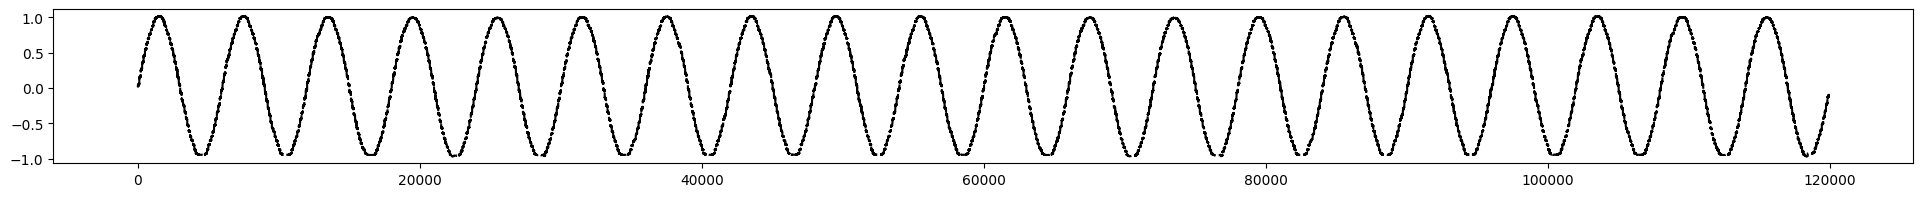

In [6]:
res = list()
test = DataLoader(arr, batch_size=32, shuffle=False)
for d in test:
    rec = model(d.to("cuda"))
    res += [rec.cpu().detach()]
plt.figure(figsize = (24, 2))
plt.plot(torch.vstack(res).reshape(-1, 1), color = "black", linestyle = "--")

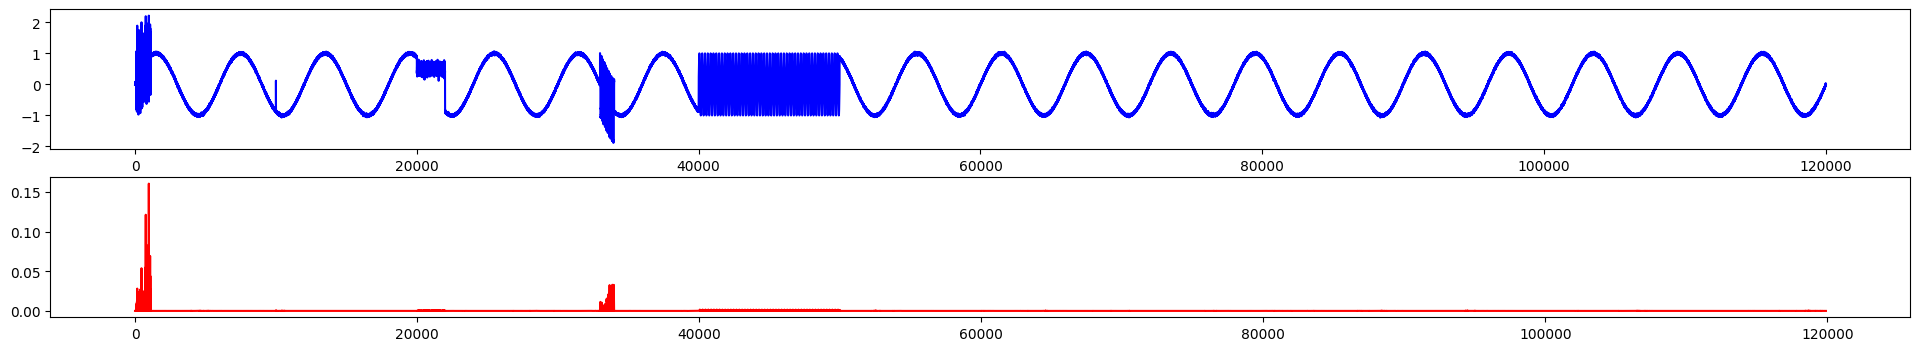

In [7]:
anomaly_temp = np.sin(np.linspace(0, 40*np.pi, 120000)) + np.random.normal(0, 0.02, 120000)
anomaly_temp[100:1100] += np.random.normal(0, 0.5, 1000)
anomaly_temp[10000] += 1
anomaly_temp[20000: 22000] = np.random.normal(.5, 0.1, 2000)
anomaly_temp[33000: 34000] += np.cos(np.linspace(0, 20*np.pi, 1000))
anomaly_temp[40000:50000] = np.sin(np.linspace(0, 100*np.pi, 10000))
anomaly_arr = list()
for i in range(0, anomaly_temp.shape[0] - LENGTH, LENGTH):
    s = torch.tensor(anomaly_temp[i:i+LENGTH], dtype = torch.float32)
    if s.shape[0] == LENGTH:
        anomaly_arr += [s]
anomaly_arr = torch.vstack(anomaly_arr).reshape(N_BATCH, LENGTH, N_SERIES)
scores = model.anomaly_score(anomaly_arr)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize = (24, 4))
ax0, ax1 = ax
ax0.plot(anomaly_temp, color = "blue")
ax1.plot(scores.cpu().detach().numpy(), color = "red")

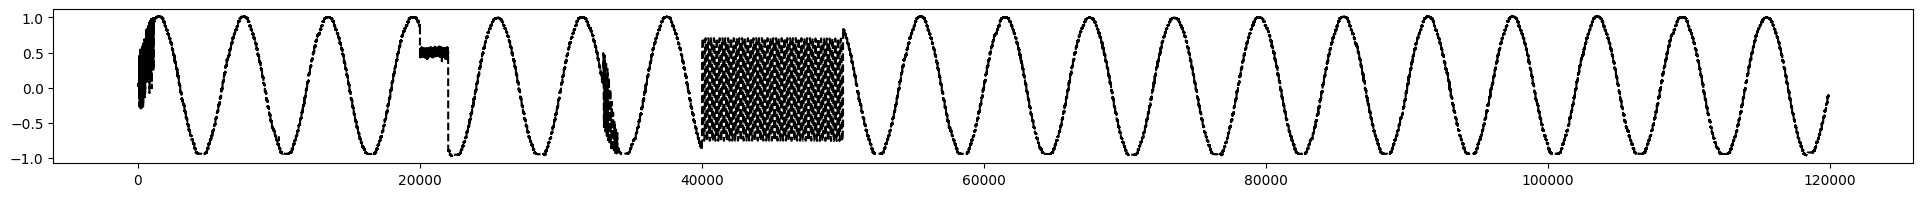

In [8]:
res = list()
test = DataLoader(anomaly_arr, batch_size=32, shuffle=False)
for d in test:
    rec = model(d.to("cuda"))
    res += [rec.cpu().detach()]
plt.figure(figsize = (24, 2))
plt.plot(torch.vstack(res).reshape(-1, 1), color = "black", linestyle = "--")

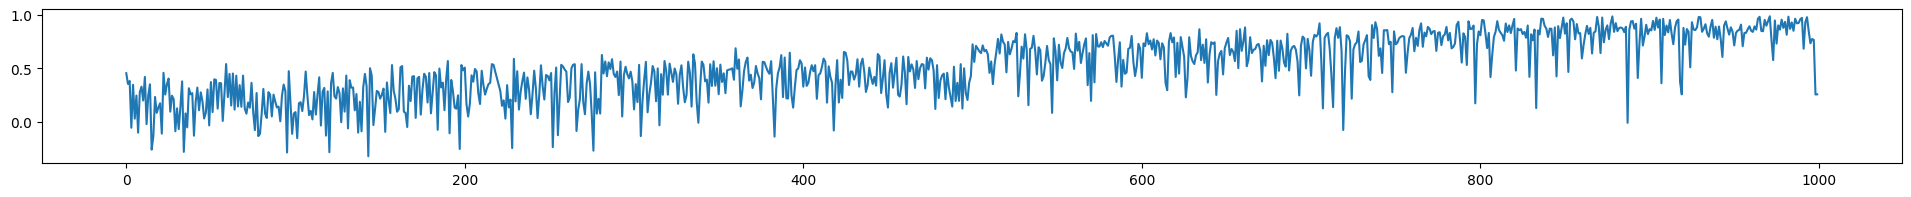

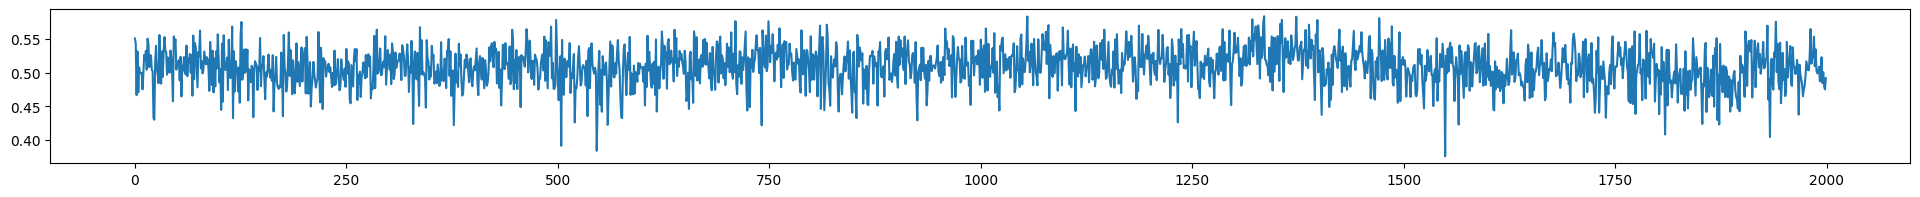

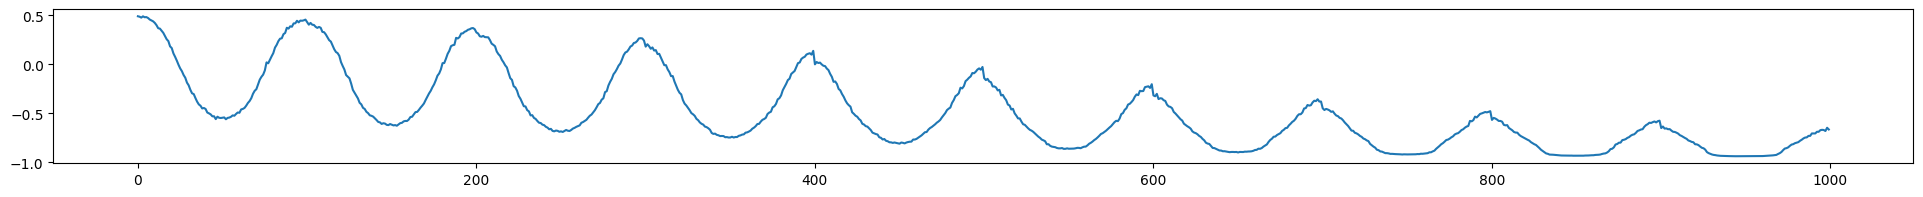

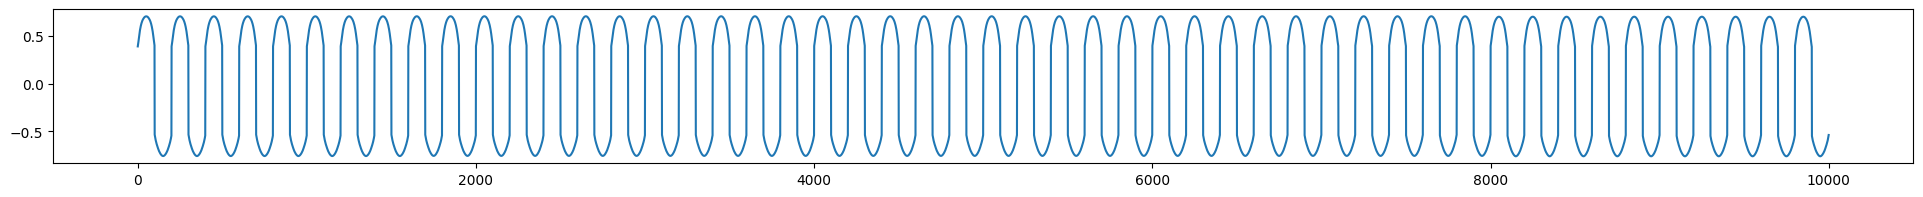

In [13]:
plt.figure(figsize = (24, 2))
plt.plot(torch.vstack(res).reshape(-1, 1)[100: 1100])
plt.show()

plt.figure(figsize = (24, 2))
plt.plot(torch.vstack(res).reshape(-1, 1)[20000: 22000])
plt.show()

plt.figure(figsize = (24, 2))
plt.plot(torch.vstack(res).reshape(-1, 1)[33000: 34000])
plt.show()

plt.figure(figsize = (24, 2))
plt.plot(torch.vstack(res).reshape(-1, 1)[40000:50000])
plt.show()